In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

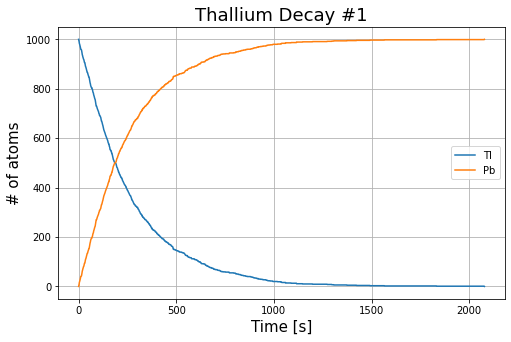

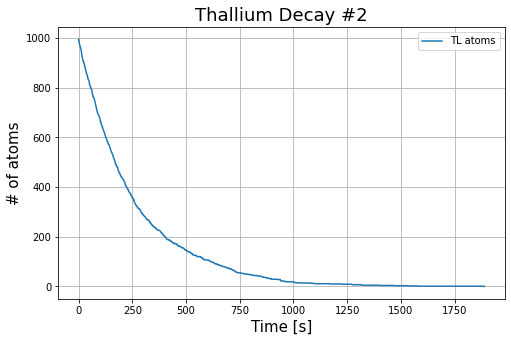

In [2]:
TL = 1000
PB = 0
tau = 3.052*60
ts = 1

TL_plot = [1000]
PB_plot = [0]
TL_t = TL
PB_t = PB
decayed = 0

while(TL_t > 0):
    for i in range(TL_t):
        if np.random.uniform(0,1) < (1-2**(-ts/tau)):
            decayed += 1  
            
    TL_t = TL - decayed
    PB_t = PB + decayed

    
    TL_plot.append(TL_t)
    PB_plot.append(PB_t)
   
plt.figure(figsize=(8,5))

plt.title("Thallium Decay #1", fontsize=18)
plt.xlabel("Time [s]", fontsize=15)
plt.ylabel("# of atoms", fontsize=15)

plt.plot(np.arange(len(TL_plot)), TL_plot, label="Tl")
plt.plot(np.arange(len(PB_plot)), PB_plot, label="Pb")

plt.legend()
plt.grid()

#SECOND PART


def prob(m):
    return (-1/m)*np.log(1-np.random.rand())

m = np.log(2)/tau
T = []
TL_plot = []

for i in range(TL):
    T.append(prob(m))

TL_t = TL
t = 0
while TL_t > 0:
    t+=ts
    TL_t = TL
    
    for i in range(TL):
        if T[i]<t:
            TL_t -= 1
    TL_plot.append(TL_t)
    
    
plt.figure(figsize=(8,5))


plt.title("Thallium Decay #2", fontsize=18)
plt.xlabel("Time [s]", fontsize=15)
plt.ylabel("# of atoms", fontsize=15)


plt.plot(np.arange(len(TL_plot)), TL_plot, label="TL atoms")

plt.legend()
plt.grid()
plt.show()


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [3]:
E = 7.7*10**6 #[eV]
epsilon0 = 8.8542*10**-12
Z = 79
e = 1.6022*10**-19 #[Coulomb]
threashold = np.pi/2
N = 1000000
a_0 = 5.292*10**-11           
std = a_0/100


def func(N, th, E, Z, std):
    E = e*E 
    frac=0
    
    def imp_par(std):
        return (-2*(std**2)*np.log(1-np.random.rand()))**(1/2)
                          
    def theta(Z,E,std):
        return (2*np.arctan((Z*e*e)/(2*np.pi*epsilon0*E*imp_par(std))))        
                           
    for i in range(N):
        if theta(Z,E,std)>th:
                frac+=1
    
    return (frac/N) 


f = func(N, threashold, E, Z, std)                
print('The fraction of alpha particles that bounced back is ',f)   

The fraction of alpha particles that bounced back is  0.001583


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [7]:
from scipy.integrate import quad

def func(x):
        return (np.sin(1/(x*(2-x))))**2


def integral_MC(a,b,N):   
    
    
    res = 0
    for i in range(N):
        if np.random.rand()<func(np.random.uniform(a,b)):
            res+=1
    
    return  res*(b-a)/(N)


def integral_mv(a,b,N):
    
    res = 0
    for i in range(N):
        res+=func(np.random.uniform(a,b))
    
    return  (res*(b-a))/(N)


a = 0 
b = 2
N = 10000

MC = integral_MC(a,b,N)
mv = integral_mv(a,b,N)
real_I = quad(func, 0, 2)[0]

error_MC = round(abs(MC-real_I)/real_I*100,3)
error_mv = round(abs(mv-real_I)/real_I*100, 3)

print("Integral value = ", real_I)
print('Monte Carlo integration value = ' + str(MC) +  " Error = " + str(error_MC) + "%")
print('Mean value integration value: ' + str(mv) + " Error = " + str(error_mv)+ "%" )






Integral value =  1.4516877509810684
Monte Carlo integration value = 1.4582 Error = 0.449%
Mean value integration value: 1.4497084521504942 Error = 0.136%


<ipython-input-7-d0ca45090dbf>:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_I = quad(func, 0, 2)[0]


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [8]:
radius = 1
N = 100000

def MC_integration(N):
    res = 0
    for i in range(N):
        x = np.random.rand()
        y = np.random.rand()
        if (x**2 + y**2) < radius:
            res += 1
    return (4.0 * radius * res) / N



def MC_integration_ND(N, d, radius=1.0):
    res = 0
    for i in range(N):
        x = np.random.rand(d)
        if x.dot(x.T) < radius:
            res += 1
    return (((2 * radius)**d) * res) / N

print("Circle Volume: " + str(MC_integration(N)))
print("10D sphere volume: " + str(MC_integration_ND(N, 10)))

Circle Volume: 3.14244
10D sphere volume: 2.85696


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [10]:

def func(x):
    return (x**(-0.5))/(np.exp(x)+1)



def imp_samp_int(a,b,N):

    def w(x):
        return 1/x**(-0.5)

    def int_weight(a,b):
        return (2*(b**(0.5)-a**(0.5)))
    
    res = 0
    for i in range(N):
        x=np.random.rand()
        res+=(func(x)*w(x))
    
    return ((res*int_weight(a,b))/N)
    
    
a = 0   
b = 1
N = 100000
    
I = imp_samp_int(a,b,N)
    
print('Importance sampling Monte Carlo result: ',I)    

    

Importance sampling Monte Carlo result:  0.7597709410873195
